In [12]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [13]:
# SPDX-License-Identifier: BSD-3-Clause
# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# # Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Sparsity with L1 penalty: 79.04%
Test score with L1 penalty: 0.8320
Example run in 6.444 s


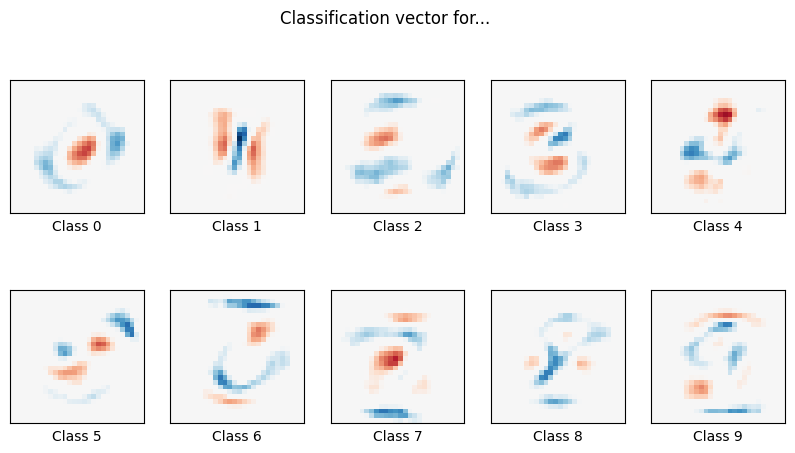

In [14]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [15]:
# FFNN from Sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2 hidden layers (100 neurons each)
ffnn = MLPClassifier(hidden_layer_sizes=(200, 200), activation='relu', solver='adam', max_iter=50)
ffnn.fit(X_train, y_train)
ffnn.score(X_test, y_test)

0.9358

Epoch 1/100 - Loss: 0.0888
Epoch 2/100 - Loss: 0.0473
Epoch 3/100 - Loss: 0.0415
Epoch 4/100 - Loss: 0.0377
Epoch 5/100 - Loss: 0.0353
Epoch 6/100 - Loss: 0.0330
Epoch 7/100 - Loss: 0.0313
Epoch 8/100 - Loss: 0.0297
Epoch 9/100 - Loss: 0.0284
Epoch 10/100 - Loss: 0.0272
Epoch 11/100 - Loss: 0.0260
Epoch 12/100 - Loss: 0.0252
Epoch 13/100 - Loss: 0.0242
Epoch 14/100 - Loss: 0.0232
Epoch 15/100 - Loss: 0.0224
Epoch 16/100 - Loss: 0.0216
Epoch 17/100 - Loss: 0.0208
Epoch 18/100 - Loss: 0.0204
Epoch 19/100 - Loss: 0.0197
Epoch 20/100 - Loss: 0.0191
Epoch 21/100 - Loss: 0.0186
Epoch 22/100 - Loss: 0.0184
Epoch 23/100 - Loss: 0.0174
Epoch 24/100 - Loss: 0.0171
Epoch 25/100 - Loss: 0.0169
Epoch 26/100 - Loss: 0.0162
Epoch 27/100 - Loss: 0.0159
Epoch 28/100 - Loss: 0.0154
Epoch 29/100 - Loss: 0.0155
Epoch 30/100 - Loss: 0.0153
Epoch 31/100 - Loss: 0.0144
Epoch 32/100 - Loss: 0.0144
Epoch 33/100 - Loss: 0.0141
Epoch 34/100 - Loss: 0.0139
Epoch 35/100 - Loss: 0.0133
Epoch 36/100 - Loss: 0.0137
E

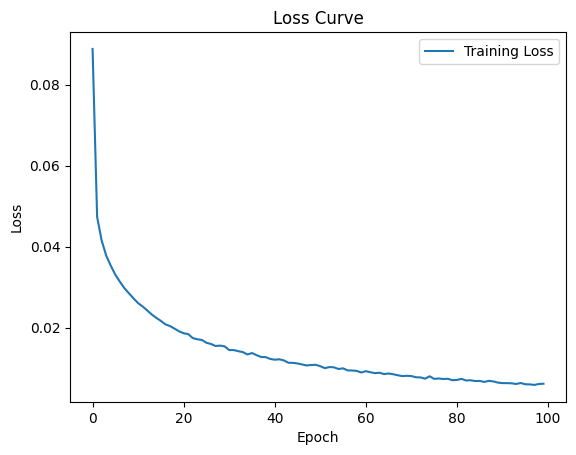

Akurasi pada data test: 91.42%

Akurasi MLPClassifier pada data test: 91.39%

Perbandingan Akurasi:
FFNN Accuracy: 91.42%
MLPClassifier Accuracy: 91.39%



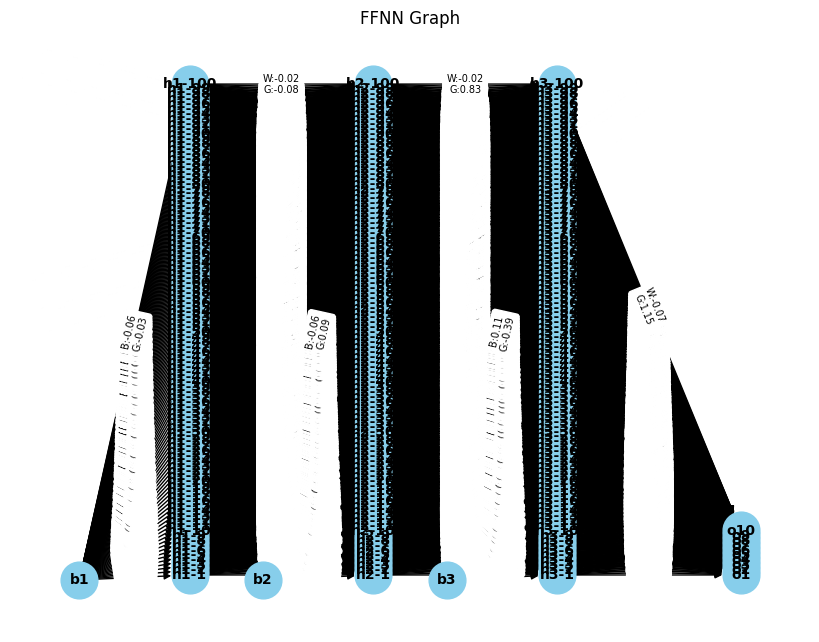

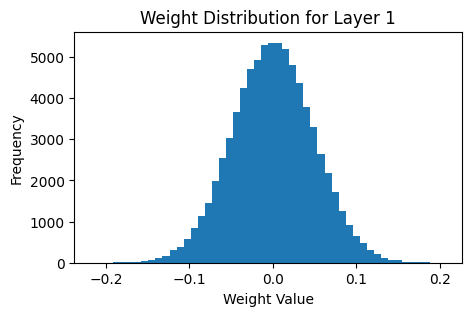

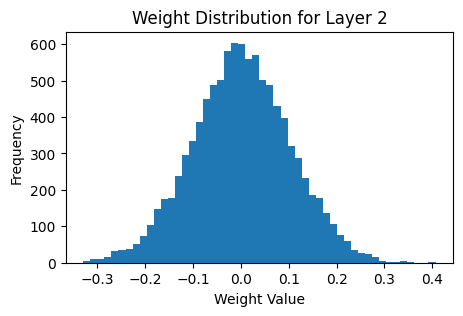

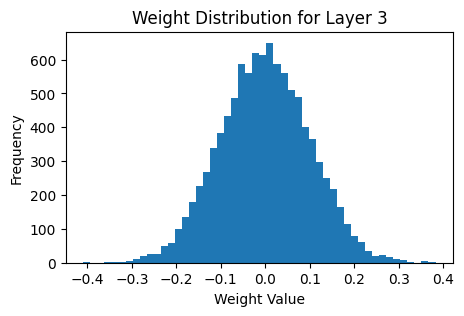

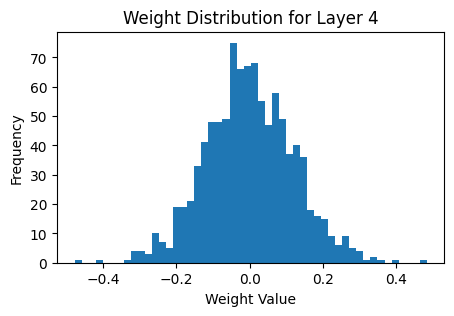

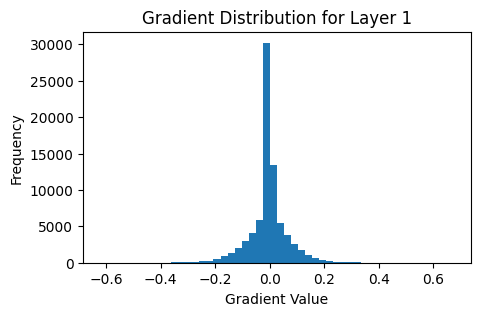

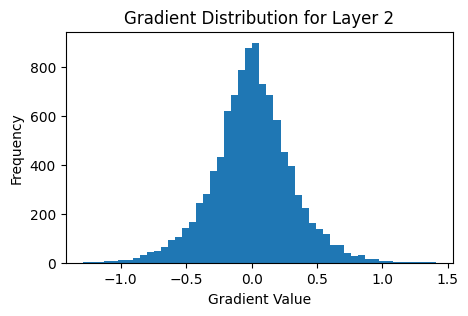

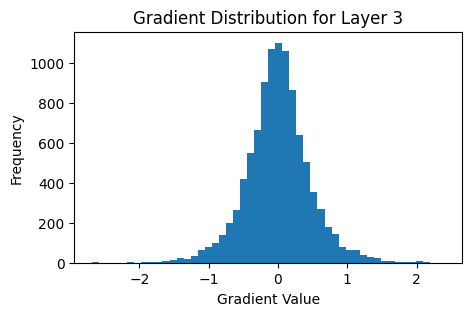

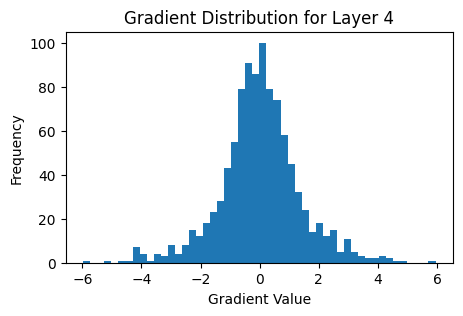

In [19]:
from importlib import reload
import main 
reload(main)
from main import FFNN
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

def main(X_train, X_test, y_train, y_test):
    load_choice = input("Apakah ingin Load Model? (y/n): ")
    if load_choice == 'y':
        file = input("Masukkan nama file: ")
        model = FFNN(layers=[], activation_functions=[])
        model.load_model(file)
        print("Model berhasil dimuat.")
    
        activations, _ = model.forward(X_test)
        y_pred = np.argmax(activations[-1], axis=1)
        
        encoder = OneHotEncoder(sparse_output=False)
        y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1))
        y_true = np.argmax(y_test_encoded, axis=1)
        accuracy = np.mean(y_pred == y_true)
        print("Akurasi pada data test: %.2f%%" % (accuracy * 100))

        layer_input = input("Layer mana yang mau dilihat distribusinya? (misal: 1 2) ")
        layer_idx = [int(layer) - 1 for layer in layer_input.split()] if layer_input else []
        model.plot_model_structure()
        model.weight_dist_plot(layer_idx)
        model.grad_dist_plot(layer_idx)
    else:
        default_n_layer = 3
        default_neurons = [100, 100, 100]
        default_activation = "swish"
        default_loss = "mse"
        default_weight_method = "xavier"
        default_learning_rate = 0.001
        default_epochs = 100
        default_batch_size = 200
        default_regularization = None
        default_lambda_reg = 0.01
        default_verbose = 1
        default_rms_norm = False
        default_layer_input = None

        # Input jumlah layer
        n_layer = input(f"Masukkan jumlah hidden layer ({default_n_layer}): ")
        n_layer = int(n_layer) if n_layer else default_n_layer

        # Input jumlah neuron per layer
        arr_of_layer = [X_train.shape[1]]
        for i in range(n_layer):
            temp = input(f"Masukkan jumlah neuron hidden layer ke-{i+1} ({default_neurons[i] if i < len(default_neurons) else 100}): ")
            temp = int(temp) if temp else (default_neurons[i] if i < len(default_neurons) else 100)
            arr_of_layer.append(temp)
        
        arr_of_layer.append(len(set(y_train)))  # Jumlah neuron di output layer

        # Input activation function
        act_functions = input(f"Masukkan jenis activation function ({default_activation}): ")

        # Validasi untuk penyesuaian dengan MLP Scikit-Learn
        valid_act = ['linear', 'sigmoid', 'relu', 'tanh']
        
        if act_functions == 'linear':
            act_functions_mlp = 'identity'
        elif act_functions == 'sigmoid':
            act_functions_mlp = 'logistic'
        else:
            act_functions_mlp = act_functions if act_functions else default_activation

        arr_of_act = [act_functions] * (n_layer + 1)

        # Input loss function
        loss_func = input(f"Masukkan jenis loss function ({default_loss}): ")
        loss_func = loss_func if loss_func else default_loss

        # Input weight initialization method
        w_method = input(f"Masukkan jenis inisialisasi weight ({default_weight_method}): ")
        w_method = w_method if w_method else default_weight_method

        # Jika weight_method adalah uniform atau normal, minta parameter tambahan
        if w_method == 'uniform':
            low_bound = input("Masukkan batas bawah untuk uniform distribution (-1): ")
            up_bound = input("Masukkan batas atas untuk uniform distribution (1): ")
            low_bound = float(low_bound) if low_bound else -1
            up_bound = float(up_bound) if up_bound else 1
            mean = None
            variance = None
        elif w_method == 'normal':
            mean = input("Masukkan nilai mean untuk normal distribution (0.0): ")
            variance = input("Masukkan nilai variance untuk normal distribution (0.1): ")
            mean = float(mean) if mean else 0.0
            variance = float(variance) if variance else 0.1
            low_bound = None
            up_bound = None
        else:
            low_bound, up_bound, mean, variance = None, None, None, None

        # Input hyperparameter lainnya
        learning_rate = input(f"Masukkan learning rate ({default_learning_rate}): ")
        learning_rate = float(learning_rate) if learning_rate else default_learning_rate

        epochs = input(f"Masukkan jumlah epoch ({default_epochs}): ")
        epochs = int(epochs) if epochs else default_epochs

        batch_size = input(f"Masukkan ukuran batch ({default_batch_size}): ")
        batch_size = int(batch_size) if batch_size else default_batch_size

        # Input regularization
        reg = input(f"Apakah menggunakan regularization? (l1/l2) (default: {default_regularization}): ")
        reg = reg.lower() if reg else default_regularization

        if reg in ['l1', 'l2']:
            lambda_reg = input(f"Masukkan nilai lambda regularization ({default_lambda_reg}): ")
            lambda_reg = float(lambda_reg) if lambda_reg else default_lambda_reg
        else:
            lambda_reg = None
            reg = None

        # Input verbose
        verbose = input(f"Masukkan verbose (0 = tidak tampil, 1 = tampil progress bar) ({default_verbose}): ")
        verbose = int(verbose) if verbose else default_verbose

        # Input RMS Normalization
        rms_n = input(f"Apakah menggunakan RMS Norm? (y/n) (default: {'y' if default_rms_norm else 'n'}): ")
        rms_n = rms_n.lower() == 'y' if rms_n else default_rms_norm

        # Membuat model FFNN
        model = FFNN(
            layers=arr_of_layer,
            activation_functions=arr_of_act,
            loss_function=loss_func,
            weight_method=w_method,
            seed=42,
            regularization=reg,
            low_bound=low_bound,
            up_bound=up_bound,
            mean=mean,
            variance=variance,
            rms_norm=rms_n,
            lambda_reg=lambda_reg
        )  

        # Melatih model
        model.train(X_train, y_train, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, verbose=verbose)

        # Evaluasi pada data test

        activations, _ = model.forward(X_test)
        y_pred = np.argmax(activations[-1], axis=1)
        
        encoder = OneHotEncoder(sparse_output=False)
        y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1))
        y_true = np.argmax(y_test_encoded, axis=1)

        accuracy = np.mean(y_pred == y_true)
        print("Akurasi pada data test: %.2f%%" % (accuracy * 100))
        print()
        valid_activations = ['linear', 'sigmoid', 'relu', 'tanh']
        if act_functions not in valid_activations:
            print(f"Activation function '{act_functions}' tidak didukung oleh MLPClassifier, sehingga comparison tidak dibandingkan.")
            return
        else:
            mlp = MLPClassifier(hidden_layer_sizes=arr_of_layer[1:-1], activation=act_functions_mlp, solver='adam', learning_rate_init=learning_rate, max_iter=epochs, random_state=42)
            mlp.fit(X_train, y_train)
            accuracy_mlp = mlp.score(X_test, y_test)
            print(f"Akurasi MLPClassifier pada data test: {accuracy_mlp * 100:.2f}%")

            print("\nPerbandingan Akurasi:")
            print(f"FFNN Accuracy: {accuracy * 100:.2f}%")
            print(f"MLPClassifier Accuracy: {accuracy_mlp * 100:.2f}%")
            print()
            layer_input = input("Layer mana yang mau dilihat distribusinya? (misal: 1 2) ")
            
            layer_idx = [int(layer) - 1 for layer in layer_input.split()] if layer_input else default_layer_input

            model.plot_model_structure()
            model.weight_dist_plot(layer_idx)
            model.grad_dist_plot(layer_idx)

        save_choice = input("Apakah ingin menyimpan model latih? (y/n): ").lower()
        if save_choice == 'y':
            file = input("Masukkan nama file: ")
            model.save_model(file)
            print(f"Model disimpan di {file}")

# Menjalankan fungsi
main(X_train, X_test, y_train, y_test)


In [17]:
from importlib import reload
import main  # Memastikan file 'main' diimpor
reload(main)  # Memuat ulang file main.py
from main import FFNN

ffnn_model = FFNN(
    layers=[X_train.shape[1], 100, 100, 100, 100, 100, len(set(y_train))],  # Input, hidden 1, hidden 2, output
    activation_functions=['swish', 'swish', 'swish', 'swish', 'swish', 'swish'],
    loss_function='mse',
    weight_method='xavier',
    seed=42,
    regularization=None,
    rms_norm=False
)
a = ffnn_model.train(X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.001, batch_size=200)
print(a)

TypeError: FFNN.train() got multiple values for argument 'epochs'

Bawah ngetes bonus

In [ ]:
# L1 regularisation (Lasso)
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha=50,max_iter=100,tol=0.1)
lasso_reg.fit(X_train,y_train)

Lasso(alpha=50, max_iter=100, tol=0.1)

In [ ]:
lasso_reg.score(X_test,y_test)

-0.0002375437494799293

In [ ]:
# L2 regularisation (Ridge)
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
ridge_reg.fit(X_train,y_train)

Ridge(alpha=50, max_iter=100, tol=0.1)

In [ ]:
ridge_reg.score(X_test,y_test)

-1.9293922899402767

[[0.46291005 0.9258201  1.38873015]
 [0.78954203 0.98692754 1.18431305]]
